#Data Preprocessing


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
# 📂 Définir la liste des fichiers d'images
image_folder_train = "data_split/train"
file_list_train = [os.path.join(image_folder_train, f) for f in os.listdir(image_folder_train) if f.endswith(('png', 'jpg', 'jpeg'))]

In [4]:
image_folder_test = "data_split/test"
file_list_test = [os.path.join(image_folder_test, f) for f in os.listdir(image_folder_test) if f.endswith(('png', 'jpg', 'jpeg'))]

In [5]:
def create_dataframe(file_list, name):
  # 📌 Dictionnaire de mapping des identifiants de races vers labels
  label_mapping = {
      "n02085620": 0, "n02085782": 1, "n02085936": 2, "n02086079": 3,
      "n02086240": 4, "n02086646": 5, "n02086910": 6, "n02087046": 7,
      "n02087394": 8, "n02088094": 9
  }

  # 📊 Extraction des labels
  image_data = []
  for img_path in file_list:
      filename = os.path.basename(img_path)  # Extrait "n02085620_12345.jpg"
      breed_id = filename.split("_")[0]  # Récupère "n02085620"

      label = label_mapping.get(breed_id, -1)  # -1 si inconnu (erreur possible)

      image_data.append([img_path, label])

  # 📊 Création du DataFrame
  df = pd.DataFrame(image_data, columns=["filename", "breed"])

  return {name: df}

In [6]:
result_train = create_dataframe(file_list_train, "df_train")
df_train = result_train["df_train"]
result_test = create_dataframe(file_list_test, "df_test")
df_test = result_test["df_test"]

In [7]:
df_train.shape

(1769, 2)

In [8]:
df_test.shape

(150, 2)

                               filename  breed
0  data_split/train\n02085620_10074.jpg      0
1  data_split/train\n02085620_10131.jpg      0
2  data_split/train\n02085620_10621.jpg      0
3   data_split/train\n02085620_1073.jpg      0
4  data_split/train\n02085620_10976.jpg      0

🔍 Distribution unique des labels :  [0 1 2 3 4 5 6 7 8 9]


C:\Users\mathi\AppData\Local\Temp\ipykernel_14748\3598754738.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, y="breed", order=df_train["breed"].value_counts().index, palette="coolwarm")


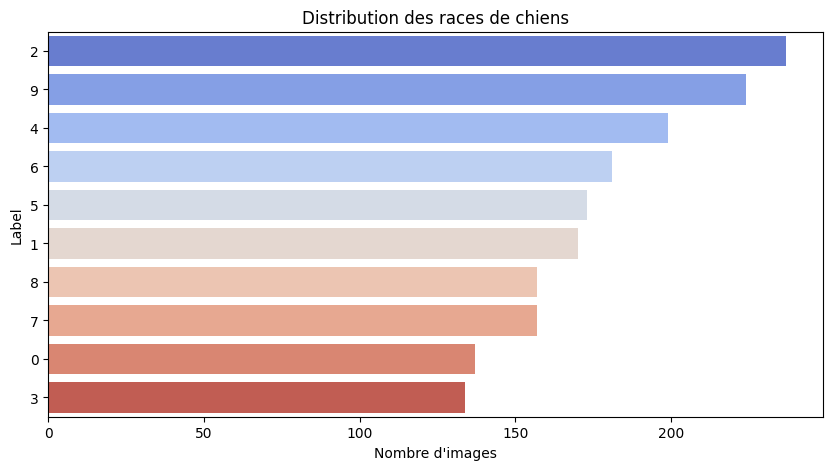

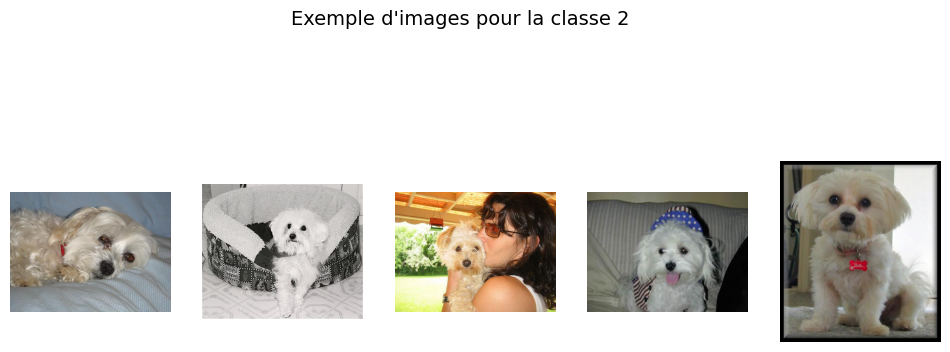

In [9]:
# 📌 Vérification des labels
print(df_train.head())
print("\n🔍 Distribution unique des labels : ", df_train["breed"].unique())

# ⚠️ Vérification des erreurs (-1 signifie que certaines images n'ont pas de label valide)
if -1 in df_train["breed"].values:
    print("⚠️ Attention : Certaines images n'ont pas été associées à un label valide.")

# 📊 Distribution des races
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, y="breed", order=df_train["breed"].value_counts().index, palette="coolwarm")
plt.title("Distribution des races de chiens")
plt.xlabel("Nombre d'images")
plt.ylabel("Label")
plt.show()

# 🖼️ Panel d'images par classe
def plot_images_by_label(df, label, num_images=5):
    """Affiche un échantillon d'images pour une race donnée."""

    # 📂 Sélectionner les fichiers correspondant au label
    selected_images = df[df["breed"] == label]["filename"].values

    if len(selected_images) == 0:
        print(f"⚠️ Aucune image trouvée pour le label {label}.")
        return

    # 🏷️ Tirer des images aléatoires
    sample_images = np.random.choice(selected_images, size=min(num_images, len(selected_images)), replace=False)

    # 🖼️ Affichage des images
    fig, axes = plt.subplots(1, len(sample_images), figsize=(12, 5))
    fig.suptitle(f"Exemple d'images pour la classe {label}", fontsize=14)

    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)  # Charger l'image
        axes[i].imshow(img)
        axes[i].axis("off")

    plt.show()

# 📌 Tester avec la classe la plus fréquente
most_common_label = df_train["breed"].value_counts().idxmax()
plot_images_by_label(df_train, most_common_label)

In [10]:
# 📊 Vérification des données avant le plot
print("📌 Aperçu du DataFrame des races :")
print(df_train.head())
print("\n🔍 Distribution unique des labels : ", df_train["breed"].unique())

📌 Aperçu du DataFrame des races :
                               filename  breed
0  data_split/train\n02085620_10074.jpg      0
1  data_split/train\n02085620_10131.jpg      0
2  data_split/train\n02085620_10621.jpg      0
3   data_split/train\n02085620_1073.jpg      0
4  data_split/train\n02085620_10976.jpg      0

🔍 Distribution unique des labels :  [0 1 2 3 4 5 6 7 8 9]


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1769 entries, 0 to 1768
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1769 non-null   object
 1   breed     1769 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.8+ KB


In [12]:
df_train.shape

(1769, 2)

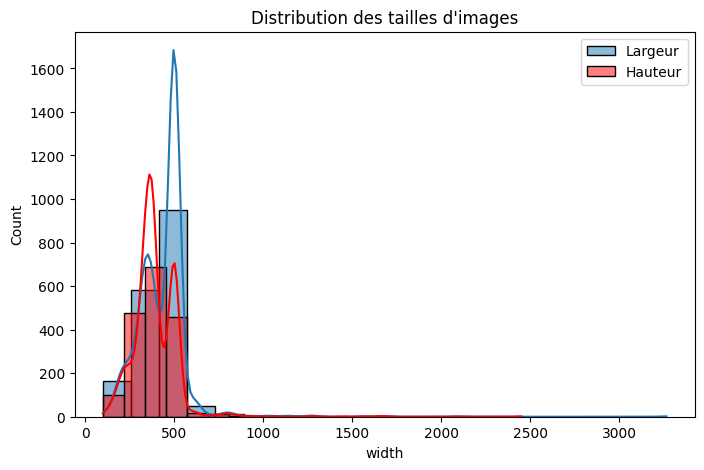

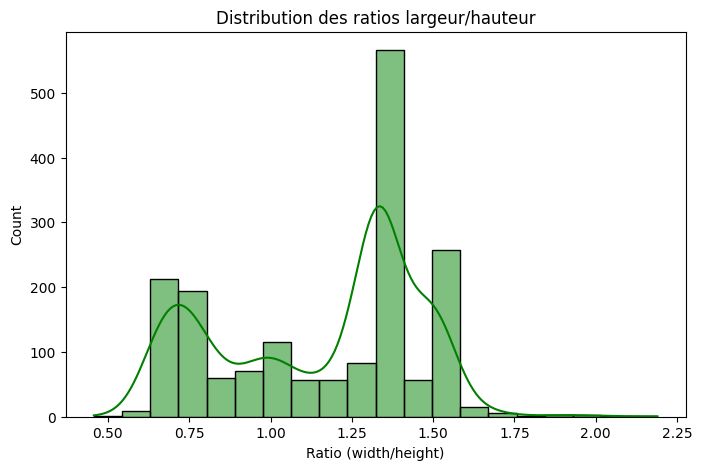

C:\Users\mathi\AppData\Local\Temp\ipykernel_14748\1980371977.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x="format", palette="pastel")


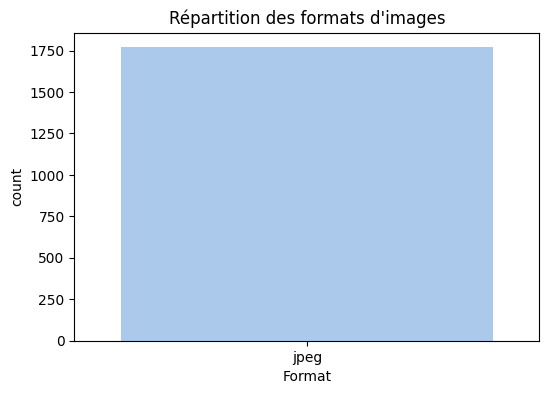

In [13]:
 # 📊 1. Extraction des tailles et formats d'image
image_sizes = []

for img_path in df_train["filename"]:
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            img_format = img.format.lower()  # Convertir en minuscule (jpeg, png...)
            image_sizes.append((width, height, img_format))
    except Exception as e:
        print(f"⚠️ Erreur lors du chargement de {img_path}: {e}")
        image_sizes.append((None, None, None))  # Gérer les erreurs

# Ajout des nouvelles colonnes au DataFrame
df_train["width"], df_train["height"], df_train["format"] = zip(*image_sizes)

# Suppression des lignes avec valeurs manquantes
df_train = df_train.dropna(subset=["width", "height", "format"])

# 📊 2. Distribution des tailles d'images
plt.figure(figsize=(8, 5))
sns.histplot(df_train["width"], bins=20, kde=True, label="Largeur")
sns.histplot(df_train["height"], bins=20, kde=True, color="red", label="Hauteur")
plt.legend()
plt.title("Distribution des tailles d'images")
plt.show()

# 📊 3. Ratios largeur/hauteur
df_train["aspect_ratio"] = df_train["width"] / df_train["height"]

plt.figure(figsize=(8, 5))
sns.histplot(df_train["aspect_ratio"], bins=20, kde=True, color="green")
plt.title("Distribution des ratios largeur/hauteur")
plt.xlabel("Ratio (width/height)")
plt.show()

# 📊 4. Nombre d'images par format
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train, x="format", palette="pastel")
plt.title("Répartition des formats d'images")
plt.xlabel("Format")
plt.show()

In [14]:
df_train.shape

(1769, 6)

In [15]:
print(img_path)

data_split/train\n02088094_988.jpg


In [16]:
print(df_train["breed"].value_counts())  # Vérifie combien d'images par label

breed
2    237
9    224
4    199
6    181
5    173
1    170
8    157
7    157
0    137
3    134
Name: count, dtype: int64


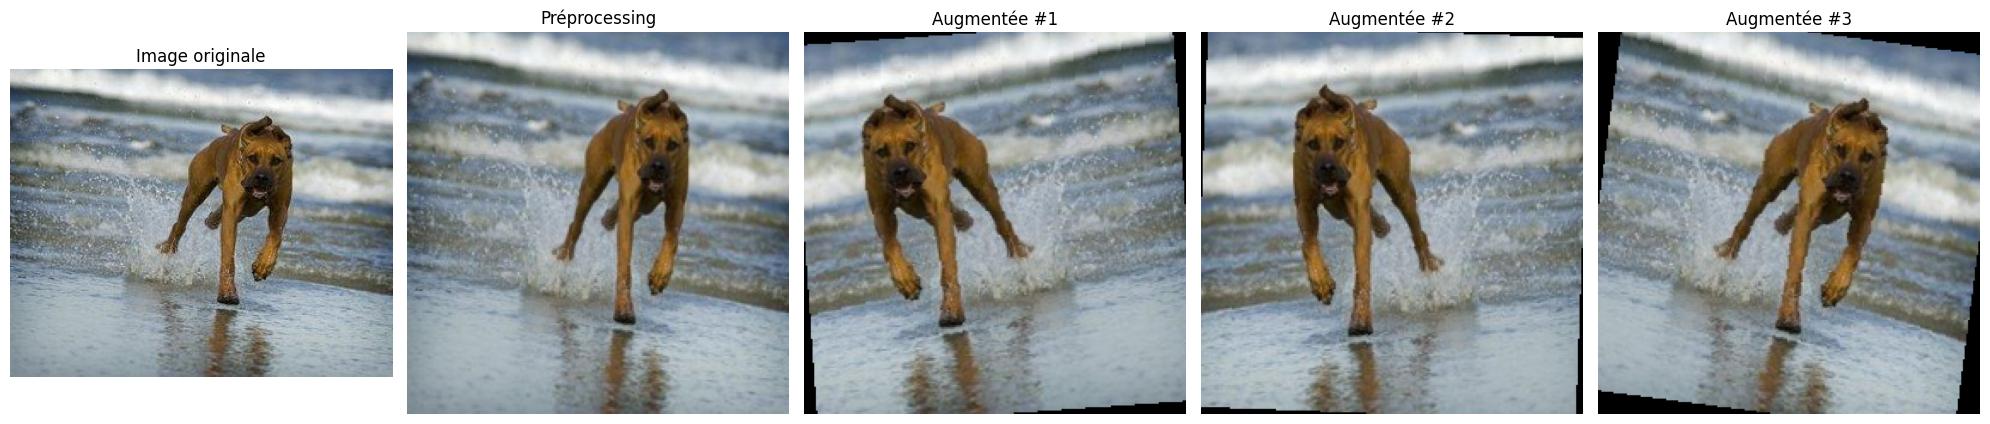

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch

# Exemple : première image du DataFrame
sample_path = df_train[df_train["breed"] == 8].iloc[0]["filename"]

# Chargement de l’image brute
original_image = Image.open(sample_path).convert("RGB")

# Préprocessing (fixe)
preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Data augmentation (aléatoire)
data_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Application des transformations
image_preprocessed = preprocessing(original_image)

# Trois versions différentes avec augmentation
augmented_versions = [data_augment(original_image) for _ in range(3)]

# Fonction utilitaire pour affichage
def tensor_to_pil(tensor):
    return transforms.ToPILImage()(tensor)

# Affichage
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].imshow(original_image)
axes[0].set_title("Image originale")
axes[0].axis("off")

axes[1].imshow(tensor_to_pil(image_preprocessed))
axes[1].set_title("Préprocessing")
axes[1].axis("off")

torch.manual_seed(42)
for i in range(3):
    axes[i+2].imshow(tensor_to_pil(augmented_versions[i]))
    axes[i+2].set_title(f"Augmentée #{i+1}")
    axes[i+2].axis("off")

plt.tight_layout()
plt.show()

In [18]:
# 💾 Sauvegarde des DataFrames train et test
df_train.to_pickle("df_train.pkl")
df_test.to_pickle("df_test.pkl")